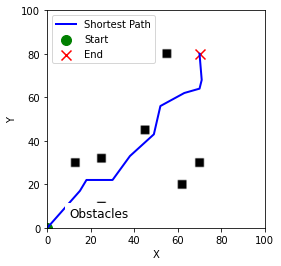

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

# Define the dimensions of the 2D environment
x_size, y_size = 100, 100

# Create a 2D grid representing the environment
grid = np.zeros((x_size, y_size), dtype=np.uint8)

# Add square obstacles with centers and side length 4
obstacle_centers = [(13, 30), (70, 30), (25, 10), (45, 45), (55, 80), (25, 32), (62, 20)]
obstacle_side = 4

for center in obstacle_centers:
    obstacle_x_start = center[0] - obstacle_side // 2
    obstacle_x_end = obstacle_x_start + obstacle_side
    obstacle_y_start = center[1] - obstacle_side // 2
    obstacle_y_end = obstacle_y_start + obstacle_side
    grid[obstacle_x_start:obstacle_x_end, obstacle_y_start:obstacle_y_end] = 1

# Define the start and end points
start = (0, 0)
end = (70, 80)

# Define a function to check if a point is within the bounds and not blocked by an obstacle
def is_valid(point):
    x, y = point
    return 0 <= x < x_size and 0 <= y < y_size and grid[x, y] == 0

# Generate random valid points for PRM sampling
def generate_random_point():
    while True:
        point = (random.randint(0, x_size - 1), random.randint(0, y_size - 1))
        if is_valid(point):
            return point

# PRM algorithm to find the path
def prm(start, end, num_samples=100, num_neighbors=5):
    nodes = [start, end]
    edges = []
    
    for _ in range(num_samples):
        sample = generate_random_point()
        if is_valid(sample):
            nodes.append(sample)
    
    # Build a nearest neighbors data structure for efficient query
    nn = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree').fit(nodes)
    
    for node in nodes:
        distances, indices = nn.kneighbors([node], num_neighbors)
        for i in indices[0]:
            if node == nodes[i]:
                continue
            if all(is_valid(point) for point in interpolate(node, nodes[i])):
                edges.append((node, nodes[i]))
    
    # Find a path using a graph search algorithm (e.g., A*)
    path = a_star(start, end, nodes, edges)
    
    return path

# Linear interpolation between two points
def interpolate(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = max(abs(x2 - x1), abs(y2 - y1))
    if distance == 0:
        return [point1]
    x_values = np.linspace(x1, x2, distance)
    y_values = np.linspace(y1, y2, distance)
    return [(int(x), int(y)) for x, y in zip(x_values, y_values)]

# A* algorithm to find the shortest path
def a_star(start, end, nodes, edges):
    open_set = [start]
    came_from = {}
    g_score = {node: float('inf') for node in nodes}
    g_score[start] = 0
    
    while open_set:
        current = open_set[0]
        for node in open_set[1:]:
            if g_score[node] < g_score[current]:
                current = node
        
        open_set.remove(current)
        
        if current == end:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path
        
        for neighbor in get_neighbors(current, edges):
            tentative_g_score = g_score[current] + distance(current, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                if neighbor not in open_set:
                    open_set.append(neighbor)
    
    return []

# Get neighboring nodes connected to the current node
def get_neighbors(node, edges):
    neighbors = []
    for edge in edges:
        if edge[0] == node:
            neighbors.append(edge[1])
        elif edge[1] == node:
            neighbors.append(edge[0])
    return neighbors

# Calculate the Euclidean distance between two points
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Find the path using PRM
path = prm(start, end)

# Extract x and y coordinates from the path if it's not empty
if path:
    path_x, path_y = zip(*path)
else:
    path_x, path_y = [], []

# Create a 2D plot
plt.figure()
plt.imshow(grid.T, origin='lower', cmap='binary', extent=(0, x_size, 0, y_size))
plt.plot(path_x, path_y, label='Shortest Path', linewidth=2, color='blue')
plt.scatter(start[0], start[1], label='Start', c='green', marker='o', s=100)
plt.scatter(end[0], end[1], label='End', c='red', marker='x', s=100)

# Add legend for obstacles
plt.text(10, 5, 'Obstacles', fontsize=12, color='black', backgroundcolor='white')

# Set labels
plt.xlabel('X')
plt.ylabel('Y')

# Add a legend explaining the elements
plt.legend()

# Show the plot
plt.show()
